In [1]:
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import torch.nn as nn
import torch
import torch.optim as optim


Monte Carlo Simulation

In [2]:
# Set seed and generate samples once
np.random.seed(46)

xi_samples = 10**5
xi = np.random.normal(0, 1, xi_samples)

alpha = 0.95
x_val = 20

# Monte Carlo inner expectation
def inner_func_Monte(a, s, x, alpha=alpha):
    term = np.maximum((x + a + xi)**2 - s, 0)
    expectation = np.mean(term)
    return x**2 + a**2 + (1/(1 - alpha)) * expectation

# Minimize over a for fixed s
def optimal_a(s, x=x_val, alpha=alpha):
    res = minimize(inner_func_Monte, x0=0, args=(s, x, alpha), 
                   method='L-BFGS-B', bounds=[(-10,10)])
    return res.x[0]

# Outer function: s + minimized inner value
def outer_func(s, x=x_val, alpha=alpha):
    a_star = optimal_a(s, x, alpha)
    return s + inner_func_Monte(a_star, s, x, alpha)

In [3]:
# Solve for s*
bounds_s = [(0, 50)]  # s >= 0 and s <= 50

a_optimal_Monte = []
s_optimal_Monte = []
objective_values_Monte = []

In [4]:
x_values = np.arange(0.0, 21, 1)
s_values = np.arange(0.0, 51, 1)

# For all values of x and s find a*, s* and the optimal value
for x in x_values:
    for s in s_values:
        try:
            res_s = minimize(outer_func, x0=0.1, bounds=bounds_s, args=(x, 0.95), method='L-BFGS-B')
            a_opt = optimal_a(s, x, 0.95)
            a_optimal_Monte.append(a_opt)
            s_optimal_Monte.append(res_s.x[0])
            objective_values_Monte.append(res_s.fun)
        except Exception as e:
            print(f"Failed at x={x}, s={s}: {e}")
            a_optimal_Monte.append(np.nan)
            s_optimal_Monte.append(np.nan)
            objective_values_Monte.append(np.nan)


In [5]:
# First dataframe: all values
df_Monte = pd.DataFrame({
    'x': np.repeat(x_values, len(s_values)),
    's': np.tile(s_values, len(x_values)),
    'a*(x,s)': a_optimal_Monte
})

df_Monte

,x,s,"a*(x,s)"
0,0.0,0.0,-0.004241
1,0.0,1.0,-0.003705
2,0.0,2.0,-0.005397
3,0.0,3.0,-0.005033
4,0.0,4.0,-0.010725
...,...,...,...
1066,20.0,46.0,-10.000000
1067,20.0,47.0,-10.000000
1068,20.0,48.0,-10.000000
1069,20.0,49.0,-10.000000


In [6]:
df_df = []

# For each x, find the s that minimized outer_func (i.e. s* and V(x))
num_s = len(s_values)
for i, x in enumerate(x_values):
    # Slice the results for current x
    s_slice = s_optimal_Monte[i*num_s:(i+1)*num_s]
    obj_slice = objective_values_Monte[i*num_s:(i+1)*num_s]
    
    # Find index of minimum objective value
    min_idx = np.argmin(obj_slice)
    
    # Store x, s*(x), V(x)
    df_df.append({
        'x': x,
        's*(x)': s_slice[min_idx],
        'V(x)': obj_slice[min_idx]
    })

df_Monte_2 = pd.DataFrame(df_df)
df_Monte_2

,x,s*(x),V(x)
0,0.0,3.826384,5.554455
1,1.0,3.897822,7.419367
2,2.0,4.233754,12.950605
3,3.0,5.039254,22.066727
4,4.0,6.907277,34.544240
5,5.0,9.732121,50.105862
6,6.0,13.086679,68.672515
7,7.0,16.996859,90.239267
8,8.0,21.319664,114.805929
9,9.0,26.794877,142.378559


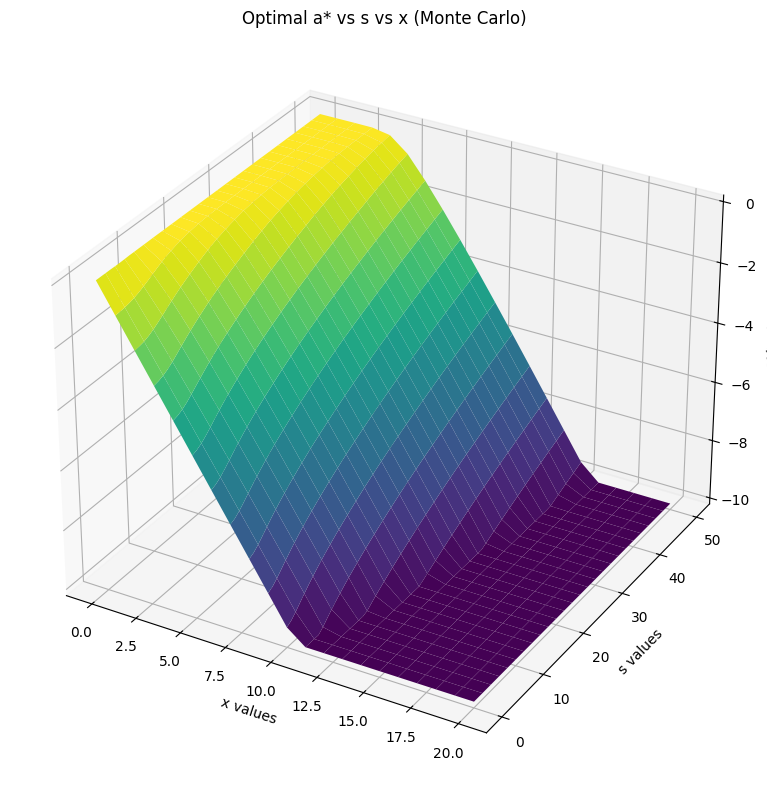

In [7]:
# Assuming df_Monte contains your data
# First, identify the unique values and create a grid
x_unique = np.sort(df_Monte['x'].unique())
s_unique = np.sort(df_Monte['s'].unique())

# Create meshgrid for proper surface plotting
X, S = np.meshgrid(x_unique, s_unique)

# Initialize the optimal action array with the right shape
A_star = np.zeros_like(X)

# Fill the grid with values from your dataframe
for i, s_val in enumerate(s_unique):
    for j, x_val in enumerate(x_unique):
        # Find the corresponding a* value in your dataframe
        mask = (df_Monte['x'] == x_val) & (df_Monte['s'] == s_val)
        if any(mask):
            A_star[i, j] = df_Monte.loc[mask, 'a*(x,s)'].values[0]

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with proper grid structure
surf = ax.plot_surface(X, S, A_star, cmap='viridis', edgecolor='none', 
                      linewidth=0, antialiased=True)

# Set labels and title
ax.set_xlabel('x values')
ax.set_ylabel('s values')
ax.set_zlabel('a*(x,s)')
ax.set_title('Optimal a* vs s vs x (Monte Carlo)')


plt.tight_layout()
plt.show()

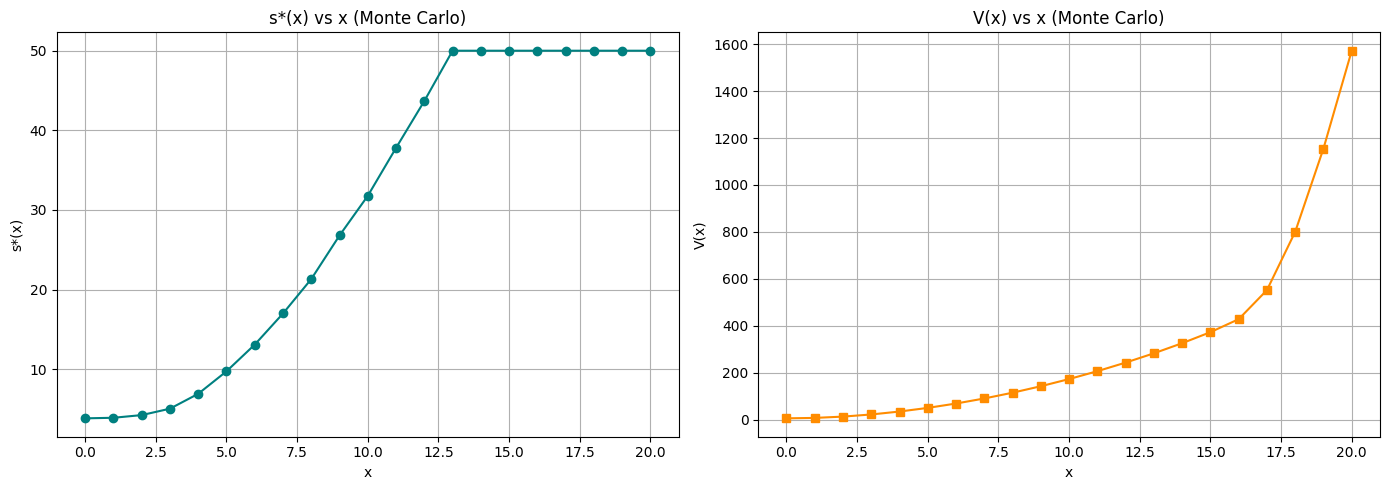

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot s*(x) vs x
axs[0].plot(df_Monte_2['x'], df_Monte_2['s*(x)'], marker='o', color='teal')
axs[0].set_title('s*(x) vs x (Monte Carlo)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('s*(x)')
axs[0].grid(True)

# Plot V(x) vs x
axs[1].plot(df_Monte_2['x'], df_Monte_2['V(x)'], marker='s', color='darkorange')
axs[1].set_title('V(x) vs x (Monte Carlo)')
axs[1].set_xlabel('x')
axs[1].set_ylabel('V(x)')
axs[1].grid(True)

plt.tight_layout()
plt.show()


Analytical Method Continued


In [11]:
# Define the inner function
def inner_func(a, s, x=1, alpha=0.95):
    u = np.sqrt(s) - x - a
    v = -np.sqrt(s) - x - a

    term1 = (x**2 + a**2 + 2*x*a - s + 1) * (1 - stats.norm.cdf(u) + stats.norm.cdf(v))
    term2 = (np.sqrt(s) + x + a) * stats.norm.pdf(u)
    term3 = (np.sqrt(s) - x - a) * stats.norm.pdf(v)

    result = x**2 + a**2 + (1 / (1 - alpha)) * (term1 + term2 + term3)
    return result

# Define function to find optimal a* for given s
def optimal_a(s, x=1, alpha=0.95):
    res = minimize(inner_func, x0=0, args=(s, x, alpha), method='L-BFGS-B', bounds=[(-10, 10)])
    return res.x[0]

# Define the outer function
def outer_func(s, x=1, alpha=0.95):
    a_star = optimal_a(s, x, alpha)
    return s + inner_func(a_star, s, x, alpha)

# Solve for s*
bounds_s = [(0, 50)]  # s >= 0 and s <= 50

a_optimal = []
s_optimal = []
objective_values = []

x_values = np.arange(0.0, 21, 1)
s_values = np.arange(0.0, 51, 1)

In [12]:
# For all values of x and s find a*, s* and the optimal value
for x in x_values:
    for s in s_values:
        res_s = minimize(outer_func, x0=0.1, bounds=bounds_s, args=(x, 0.95), method='L-BFGS-B')
        a_optimal.append(optimal_a(s, x, 0.95))
        s_optimal.append(res_s.x[0])
        objective_values.append(res_s.fun)

In [13]:
# Create a dataframe with the results
df1 = pd.DataFrame({'x': np.repeat(x_values, len(s_values)),
                   's': np.tile(s_values, len(x_values)),
                   'a*(x,s)': a_optimal})

df1

,x,s,"a*(x,s)"
0,0.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,2.0,0.0
3,0.0,3.0,0.0
4,0.0,4.0,0.0
...,...,...,...
1066,20.0,46.0,-10.0
1067,20.0,47.0,-10.0
1068,20.0,48.0,-10.0
1069,20.0,49.0,-10.0


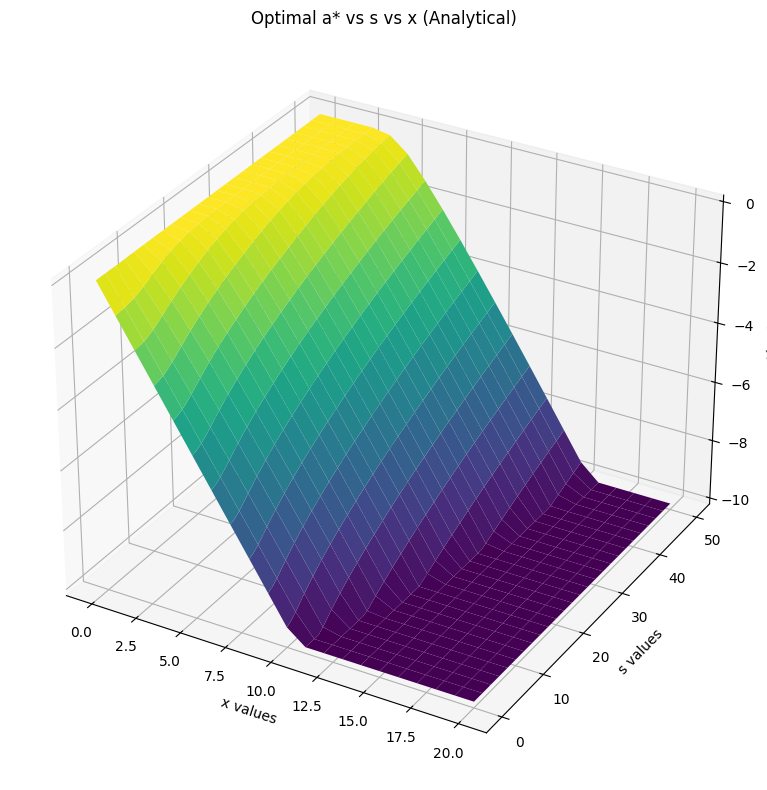

In [14]:
# Plot a*(x,s) vs x and s
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, S, A_star, cmap='viridis', edgecolor='none', linewidth=0, antialiased=True)
ax.set_xlabel('x values')
ax.set_ylabel('s values')
ax.set_zlabel('a*(x,s)')
ax.set_title('Optimal a* vs s vs x (Analytical)')
plt.tight_layout()
plt.show()



In [15]:
df2_data = []

# For each x, find the s that minimized outer_func (i.e. s* and V(x))
num_s = len(s_values)
for i, x in enumerate(x_values):
    # Slice the results for current x
    s_slice = s_optimal[i*num_s:(i+1)*num_s]
    obj_slice = objective_values[i*num_s:(i+1)*num_s]
    
    # Find index of minimum objective value
    min_idx = np.argmin(obj_slice)
    
    # Store x, s*(x), V(x)
    df2_data.append({
        'x': x,
        's*(x)': s_slice[min_idx],
        'V(x)': obj_slice[min_idx]
    })

df2 = pd.DataFrame(df2_data)
df2

,x,s*(x),V(x)
0,0.0,3.841458,5.582009
1,1.0,3.933622,7.428476
2,2.0,4.260430,12.946453
3,3.0,5.054924,22.050795
4,4.0,6.884020,34.520935
5,5.0,9.694924,50.079094
6,6.0,13.057422,68.641746
7,7.0,16.920923,90.204458
8,8.0,21.284301,114.767171
9,9.0,26.148047,142.329884


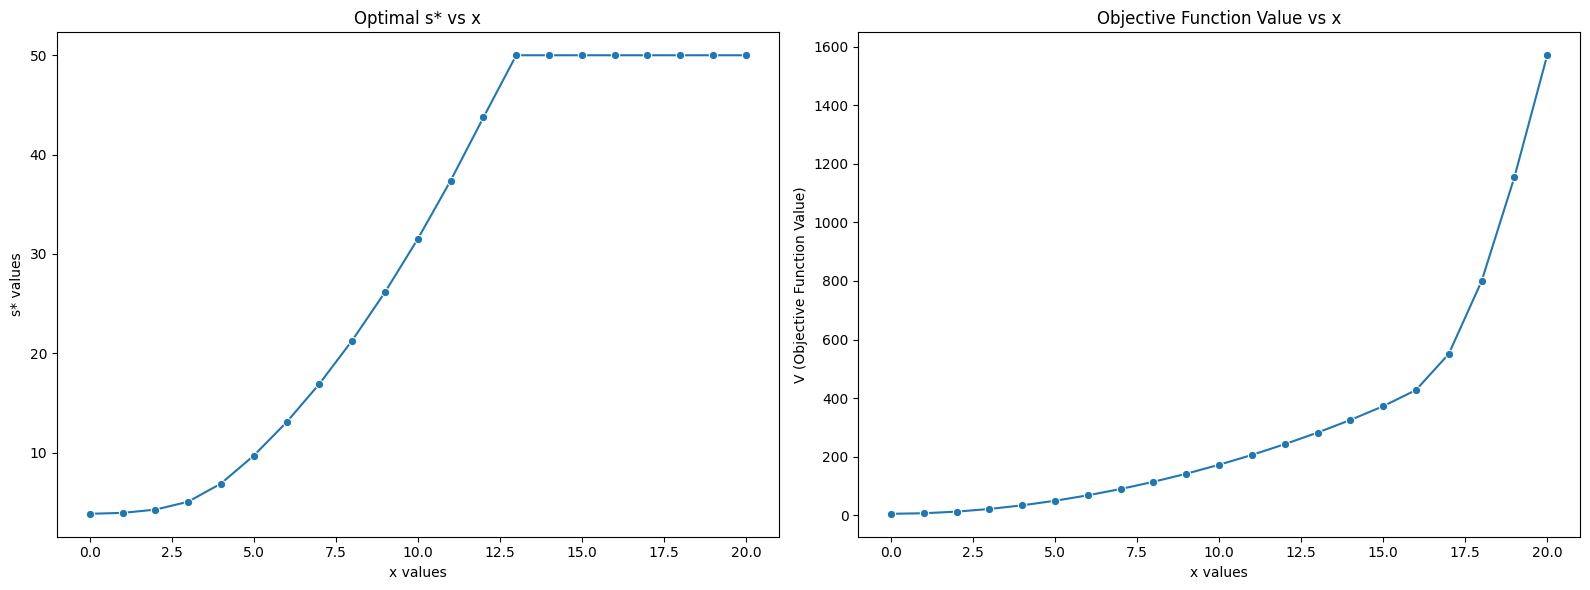

In [16]:
# Create a 1-row, 2-column subplot layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First plot (Optimal s* vs x)
sns.lineplot(x=df2['x'], y=df2['s*(x)'], marker='o', linestyle='-', ax=axes[0])
axes[0].set_xlabel('x values')
axes[0].set_ylabel('s* values')
axes[0].set_title('Optimal s* vs x')

# Second plot (Objective Function Value vs x)
sns.lineplot(x=df2['x'], y=df2['V(x)'], marker='o', linestyle='-', ax=axes[1])
axes[1].set_xlabel('x values')
axes[1].set_ylabel('V (Objective Function Value)')
axes[1].set_title('Objective Function Value vs x')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

COMPARING THE RESULTS


In [17]:
df_compare = df_Monte_2.merge(df2, on='x', suffixes=('_Monte', '_Analytical'))

df_compare['abs_error_V'] = np.abs(df_compare['V(x)_Monte'] - df_compare['V(x)_Analytical'])
df_compare['rel_error_V'] = df_compare['abs_error_V'] / np.abs(df_compare['V(x)_Analytical'])

df_compare['abs_error_s'] = np.abs(df_compare['s*(x)_Monte'] - df_compare['s*(x)_Analytical'])
df_compare['rel_error_s'] = df_compare['abs_error_s'] / np.abs(df_compare['s*(x)_Analytical'])

print(df_compare[['abs_error_V', 'rel_error_V']].describe())
print(df_compare[['abs_error_s', 'rel_error_s']].describe())


       abs_error_V  rel_error_V
count    21.000000    21.000000
mean      0.313467     0.000855
std       0.568102     0.001058
min       0.004152     0.000210
25%       0.027554     0.000274
50%       0.048675     0.000448
75%       0.082742     0.001160
max       1.820994     0.004936
       abs_error_s  rel_error_s
count    21.000000    21.000000
mean      0.080151     0.003984
std       0.165206     0.005823
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.023258     0.002241
75%       0.037197     0.004488
max       0.646830     0.024737


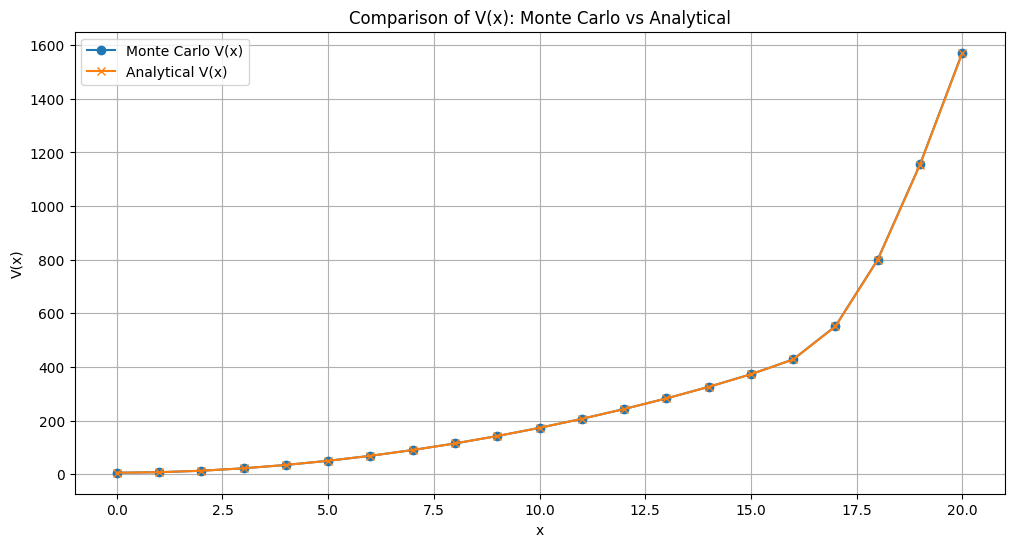

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_compare['x'], df_compare['V(x)_Monte'], label='Monte Carlo V(x)', marker='o')
plt.plot(df_compare['x'], df_compare['V(x)_Analytical'], label='Analytical V(x)', marker='x')
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title('Comparison of V(x): Monte Carlo vs Analytical')
plt.legend()
plt.grid(True)
plt.show()


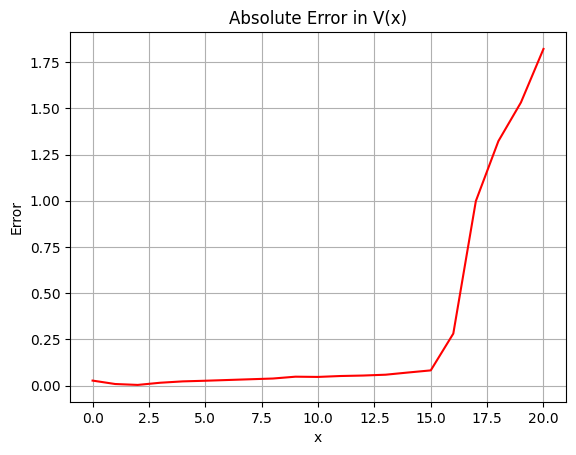

In [19]:
plt.plot(df_compare['x'], df_compare['abs_error_V'], label='Absolute Error in V(x)', color='red')
plt.title('Absolute Error in V(x)')
plt.xlabel('x')
plt.ylabel('Error')
plt.grid(True)
plt.show()


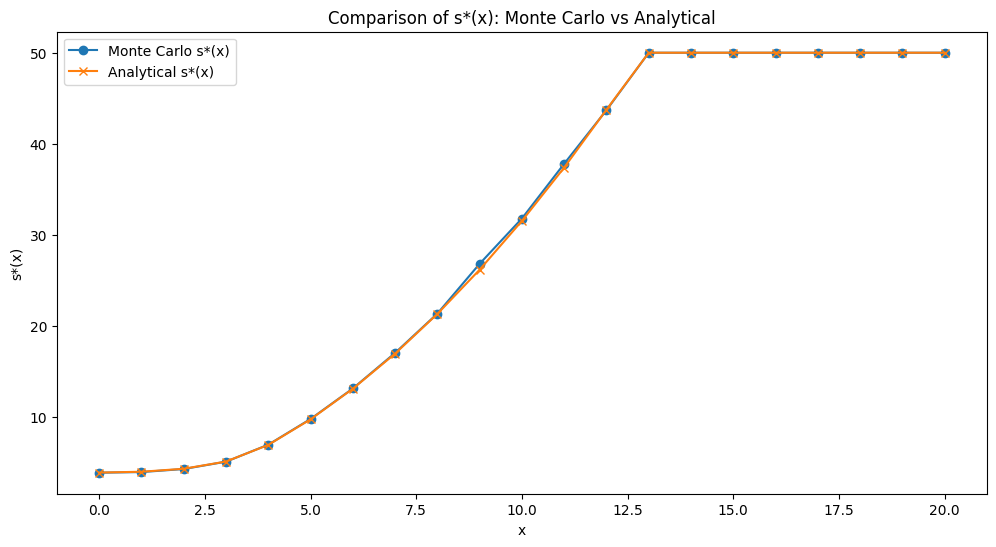

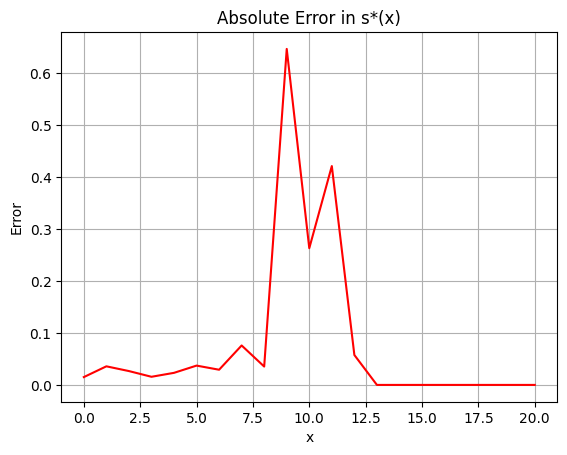

In [27]:
# Plot for s*(x) comparison and absolute error
plt.figure(figsize=(12, 6))
plt.plot(df_compare['x'], df_compare['s*(x)_Monte'], label='Monte Carlo s*(x)', marker='o')
plt.plot(df_compare['x'], df_compare['s*(x)_Analytical'], label='Analytical s*(x)', marker='x')
plt.xlabel('x')
plt.ylabel('s*(x)')
plt.title('Comparison of s*(x): Monte Carlo vs Analytical')
plt.legend()
plt.show()

plt.plot(df_compare['x'], df_compare['abs_error_s'], label='Absolute Error in s*(x)', color='red')
plt.title('Absolute Error in s*(x)')
plt.xlabel('x')
plt.ylabel('Error')
plt.grid(True)
plt.show()


In [20]:
df_a_compare = df_Monte.merge(df1, on=['x', 's'], suffixes=('_Monte', '_Analytical'))
df_a_compare['abs_error_a'] = np.abs(df_a_compare['a*(x,s)_Monte'] - df_a_compare['a*(x,s)_Analytical'])


In [21]:
df_compare = df_Monte_2.merge(df2, on='x', suffixes=('_Monte', '_Analytical'))

df_compare['abs_error_s'] = np.abs(df_compare['s*(x)_Monte'] - df_compare['s*(x)_Analytical'])
df_compare['abs_error_V'] = np.abs(df_compare['V(x)_Monte'] - df_compare['V(x)_Analytical'])


In [25]:
# Print mean absolute errors
print("Mean Absolute Error in s*(x):", df_compare['abs_error_s'].mean())
print("Mean Absolute Error in V(x):", df_compare['abs_error_V'].mean())
print('Mean absolute Error in a*(x,s):', df_a_compare['abs_error_a'].mean())

Mean Absolute Error in s*(x): 0.0801514938431001
Mean Absolute Error in V(x): 0.31346714503973233
Mean absolute Error in a*(x,s): 0.00304371715284834


In [28]:
from scipy.stats import ttest_rel

# For a*(x,s)
a_ttest = ttest_rel(df_a_compare['a*(x,s)_Monte'], df_a_compare['a*(x,s)_Analytical'])

# For s*(x)
s_ttest = ttest_rel(df_compare['s*(x)_Monte'], df_compare['s*(x)_Analytical'])

# For V(x)
v_ttest = ttest_rel(df_compare['V(x)_Monte'], df_compare['V(x)_Analytical'])

print("T-test for a*(x,s):", a_ttest)
print("T-test for s*(x):", s_ttest)
print("T-test for V(x):", v_ttest)


T-test for a*(x,s): TtestResult(statistic=np.float64(-23.295187464072054), pvalue=np.float64(2.0274182899108205e-97), df=np.int64(1070))
T-test for s*(x): TtestResult(statistic=np.float64(1.755485838479912), pvalue=np.float64(0.0944821188845073), df=np.int64(20))
T-test for V(x): TtestResult(statistic=np.float64(2.4915998409366193), pvalue=np.float64(0.021617614626278106), df=np.int64(20))


Polynomial Regression Model

In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib import cm


In [41]:
# Function to fit polynomial regression and make predictions
def polynomial_regression(X, y, degree):
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)
    
    y_pred = model.predict(X_poly)
    
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    return model, poly, y_pred, mse, r2

# Prepare feature matrices
X_a = df1[['s', 'x']].values  # Features for predicting a*
y_a = df1['a*(x,s)'].values  # Target a*

X_s = df2[['x']].values  # Feature for predicting s*
y_s = df2['s*(x)'].values  # Target s*

X_V = df2[['x']].values  # Feature for predicting V
y_V = df2['V(x)'].values  # Target V

# Train polynomial regression models
model_a, poly_a, y_a_pred, mse_a, r2_a = polynomial_regression(X_a, y_a, degree = 6)
model_s, poly_s, y_s_pred, mse_s, r2_s = polynomial_regression(X_s, y_s, degree = 10)
model_V, poly_V, y_V_pred, mse_V, r2_V = polynomial_regression(X_V, y_V, degree = 10)

# Print performance metrics
print(f"a* Prediction: MSE = {mse_a:.4f}, R² = {r2_a:.4f}")
print(f"s* Prediction: MSE = {mse_s:.4f}, R² = {r2_s:.4f}")
print(f"V Prediction: MSE = {mse_V:.4f}, R² = {r2_V:.4f}")

a* Prediction: MSE = 0.0198, R² = 0.9987
s* Prediction: MSE = 0.1647, R² = 0.9995
V Prediction: MSE = 12.8737, R² = 0.9999


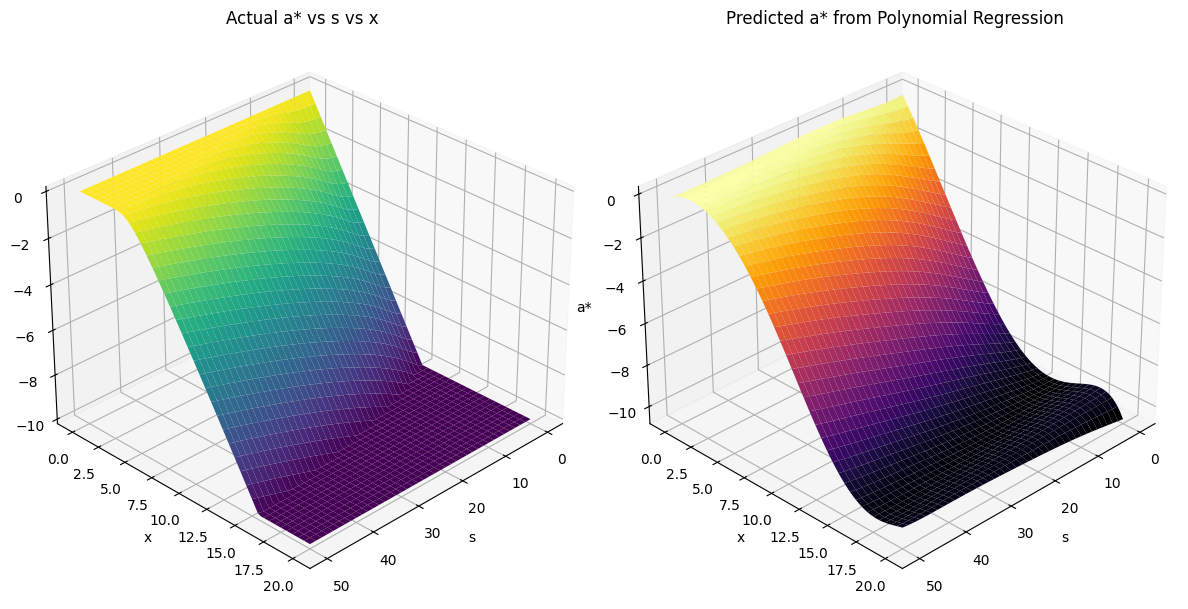

In [50]:
# Actual a*
s_vals = np.sort(df1['s'].unique())
x_vals = np.sort(df1['x'].unique())

S, X = np.meshgrid(s_vals, x_vals)

A_optimal_df = df1.pivot(index='x', columns='s', values='a*(x,s)')
A_optimal_df = A_optimal_df.reindex(index=x_vals, columns=s_vals)
A_optimal = A_optimal_df.values


# Create grid of features for prediction
X_plot = np.column_stack((S.ravel(), X.ravel()))
X_plot_poly = poly_a.transform(X_plot)
A_pred = model_a.predict(X_plot_poly).reshape(S.shape)

fig = plt.figure(figsize=(12, 6))

# Plot actual a*
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(S, X, A_optimal, cmap=cm.viridis, edgecolor='none')
ax1.set_title('Actual a* vs s vs x')
ax1.set_xlabel('s')
ax1.set_ylabel('x')
ax1.set_zlabel('a*')
ax1.view_init(elev=30, azim=45)

# Plot predicted a*
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(S, X, A_pred, cmap=cm.inferno, edgecolor='none')
ax2.set_title('Predicted a* from Polynomial Regression')
ax2.set_xlabel('s')
ax2.set_ylabel('x')
ax2.set_zlabel('a*')
ax2.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

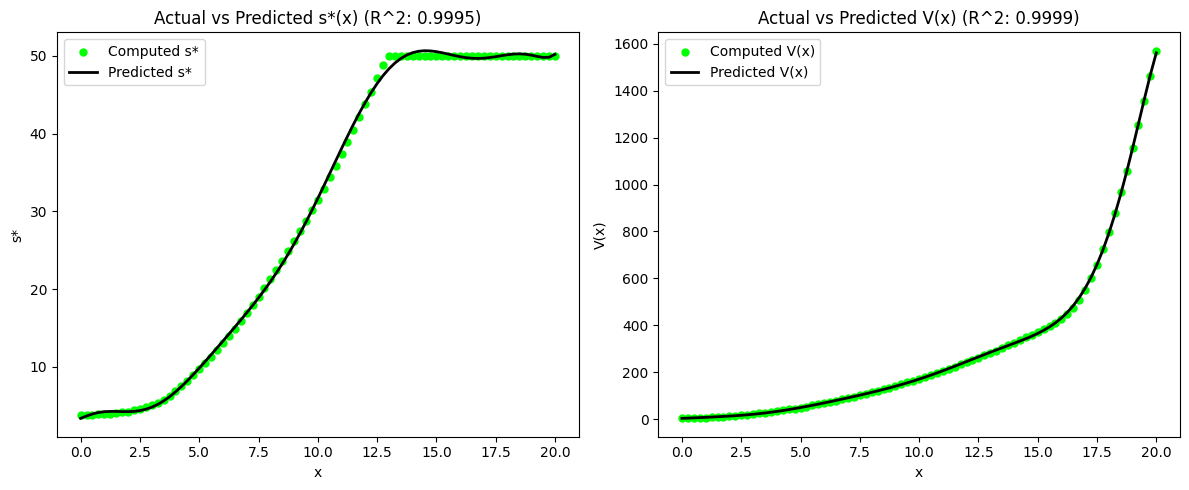

In [43]:
# Sorted values for clean plotting
df2_sorted = df2.sort_values(by='x')
x_vals = df2_sorted['x'].values

# Predict s*(x) and V(x)
X_sorted_poly_s = poly_s.transform(x_vals.reshape(-1, 1))
s_pred = model_s.predict(X_sorted_poly_s)

X_sorted_poly_V = poly_V.transform(x_vals.reshape(-1, 1))
V_pred = model_V.predict(X_sorted_poly_V)

# Plot
plt.figure(figsize=(12, 5))

# ---- s*(x) plot ----
plt.subplot(1, 2, 1)
plt.scatter(x_vals, df2_sorted['s*(x)'], color='lime', label='Computed s*', s=25)
plt.plot(x_vals, s_pred, color='black', label='Predicted s*', linewidth=2)
plt.title('Actual vs Predicted s*(x) (R^2: {:.4f})'.format(r2_s))
plt.xlabel('x')
plt.ylabel('s*')
plt.legend()

# ---- V(x) plot ----
plt.subplot(1, 2, 2)
plt.scatter(x_vals, df2_sorted['V(x)'], color='lime', label='Computed V(x)', s=25)
plt.plot(x_vals, V_pred, color='black', label='Predicted V(x)', linewidth=2)
plt.title('Actual vs Predicted V(x) (R^2: {:.4f})'.format(r2_V))
plt.xlabel('x')
plt.ylabel('V(x)')
plt.legend()

plt.tight_layout()
plt.show()


In [44]:
# Generate polynomial formula strings
def get_polynomial_formula(model, poly, feature_names):
    """Generate a string representation of the polynomial formula"""
    coefficients = model.coef_
    intercept = model.intercept_
    powers = poly.powers_
    
    formula = f"{intercept:.6f}"
    
    for i, coef in enumerate(coefficients[1:]):  # Skip the intercept term
        power = powers[i+1]  # Skip the first row which is for the intercept
        term = f"{coef:.6f}"
        
        for j, p in enumerate(power):
            if p > 0:
                term += f" * {feature_names[j]}"
                if p > 1:
                    term += f"^{p}"
        
        formula += f" + ({term})"
    
    return formula

# Generate formulas
a_formula = get_polynomial_formula(model_a, poly_a, ['s', 'x'])
s_formula = get_polynomial_formula(model_s, poly_s, ['x'])
V_formula = get_polynomial_formula(model_V, poly_V, ['x'])

print("\nPolynomial Formulas:")
print(f"\na*(x,s) = {a_formula}")
print(f"\ns*(x) = {s_formula}")
print(f"\nV(x) = {V_formula}")


Polynomial Formulas:

a*(x,s) = -0.076361 + (-0.034971 * s) + (-0.824146 * x) + (0.008205 * s^2) + (0.064213 * s * x) + (-0.065908 * x^2) + (-0.000546 * s^3) + (-0.001439 * s^2 * x) + (-0.007336 * s * x^2) + (0.011217 * x^3) + (0.000016 * s^4) + (0.000027 * s^3 * x) + (0.000164 * s^2 * x^2) + (0.000274 * s * x^3) + (-0.001075 * x^4) + (-0.000000 * s^5) + (-0.000000 * s^4 * x) + (-0.000001 * s^3 * x^2) + (-0.000007 * s^2 * x^3) + (-0.000009 * s * x^4) + (0.000070 * x^5) + (0.000000 * s^6) + (0.000000 * s^5 * x) + (0.000000 * s^4 * x^2) + (0.000000 * s^3 * x^3) + (0.000000 * s^2 * x^4) + (0.000000 * s * x^5) + (-0.000002 * x^6)

s*(x) = 3.390575 + (1.191956 * x) + (0.279136 * x^2) + (-1.107102 * x^3) + (0.627591 * x^4) + (-0.155589 * x^5) + (0.021144 * x^6) + (-0.001681 * x^7) + (0.000078 * x^8) + (-0.000002 * x^9) + (0.000000 * x^10)

V(x) = 4.042343 + (3.238331 * x) + (1.870738 * x^2) + (-1.277122 * x^3) + (0.477792 * x^4) + (-0.056986 * x^5) + (-0.001633 * x^6) + (0.000979 * x^7) + (

In [45]:
np.random.seed(42)  # For reproducibility
x_new = np.sort(np.random.uniform(0.0, 20, 15))  # 15 random values of x between 0.1 and 20
s_new = np.sort(np.random.uniform(0.0, 50, 15))  # 15 random values of s between 0.1 and 50

# Create all combinations of x and s (but limit total to ~20 as requested)
test_points = []
for i, x in enumerate(x_new):
    for j, s in enumerate(s_new):
        # Only include some combinations to keep total points reasonable
        if (i + j) % 10 == 0:  # This will select only some of the combinations
            test_points.append((x, s))

# Limit to around 20 points as requested
test_points = test_points[:15]

# Calculate actual optimal a values for test points
actual_a_values = []
for x, s in test_points:
    a_opt = optimal_a(s, x, 0.95)
    actual_a_values.append(a_opt)

# Prepare data for prediction
X_test = np.array(test_points)
X_test_for_a = X_test[:, [1, 0]]  # Swap columns to match [s, x] order for a* prediction

# Get predictions using the polynomial model
y_a_pred_test = model_a.predict(poly_a.transform(X_test_for_a))

# Create dataframe with results
results_df = pd.DataFrame({
    'x': X_test[:, 0],
    's': X_test[:, 1],
    'actual_a': actual_a_values,
    'predicted_a': y_a_pred_test,
    'absolute_error': np.abs(np.array(actual_a_values) - y_a_pred_test)
})

# Calculate metrics for test data
mse_test = mean_squared_error(actual_a_values, y_a_pred_test)
r2_test = r2_score(actual_a_values, y_a_pred_test)

print(f"Test data performance metrics:")
print(f"Mean Squared Error: {mse_test:.6f}")
print(f"R² Score: {r2_test:.6f}")
print(f"Mean Absolute Error: {results_df['absolute_error'].mean():.6f}")
print(f"Max Absolute Error: {results_df['absolute_error'].max():.6f}")

# Display the test results
print("\nTest Data Predictions vs Actual Values:")
print(results_df)

Test data performance metrics:
Mean Squared Error: 0.043319
R² Score: 0.997298
Mean Absolute Error: 0.146897
Max Absolute Error: 0.469498

Test Data Predictions vs Actual Values:
            x          s   actual_a  predicted_a  absolute_error
0    0.411690   2.322521  -0.374828    -0.413782        0.038955
1    0.411690  25.711722  -0.000165     0.061475        0.061640
2    1.161672  22.803499  -0.014339    -0.018267        0.003927
3    3.119890  21.597251  -0.855516    -0.877289        0.021773
4    3.120373  18.318092  -1.100771    -1.088467        0.012304
5    3.636499  15.212112  -1.774156    -1.711009        0.063148
6    4.246782  14.607232  -2.338857    -2.258898        0.079959
7    7.490802  14.561457  -5.217883    -5.284278        0.066394
8    7.490802  39.258798  -3.200787    -3.070369        0.130418
9   11.973170   9.983689  -9.915315    -9.449317        0.465998
10  11.973170  30.592645  -7.944171    -8.082015        0.137844
11  12.022300   9.170225 -10.000000    -9

Test data performance metrics for s*:
Mean Squared Error: 0.085230
R² Score: 0.999805
Mean Absolute Error: 0.240753
Max Absolute Error: 0.647410

Test data performance metrics for V:
Mean Squared Error: 15.321522
R² Score: 0.999904
Mean Absolute Error: 2.802774
Max Absolute Error: 8.791301

Test Data Predictions vs Actual Values:
            x   actual_s  predicted_s     actual_V  predicted_V   s_error  \
0    0.411690   3.856625     3.867640     5.895191     5.616531  0.011016   
1    1.161672   3.967590     4.277542     8.073001     9.074709  0.309952   
2    3.119890   5.207334     4.985413    23.374511    22.589097  0.221921   
3    3.120373   5.207993     4.986100    23.379934    22.594055  0.221893   
4    3.636499   6.071147     5.918047    29.619337    28.523286  0.153100   
5    4.246782   7.513323     7.471008    38.079853    37.156027  0.042315   
6    7.490802  18.999582    18.838550   101.885023   102.606727  0.161032   
7   11.973170  43.561647    43.857898   241.997867  

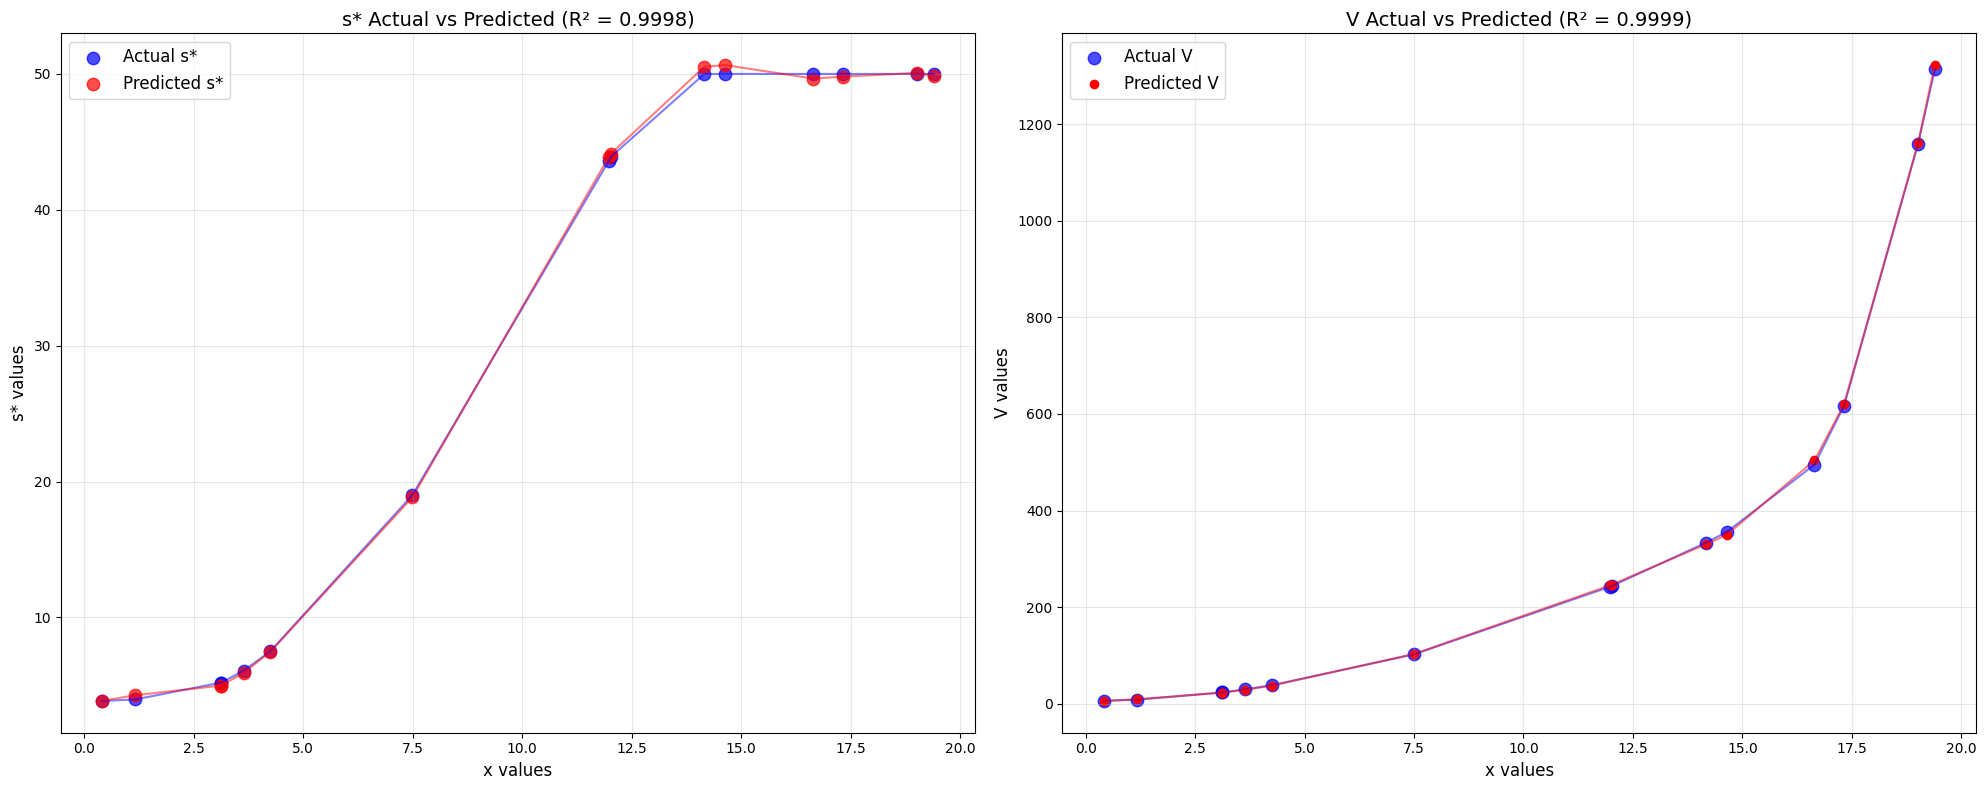

In [46]:
# Lists to store results
actual_s_values = []
actual_V_values = []

# Calculate actual s* and V values for each x
for x in x_new:
    # Find optimal s* for this x
    bounds_s = [(0, 50)]
    res_s = minimize(outer_func, x0=0.1, bounds=bounds_s, args=(x, 0.95), method='L-BFGS-B')
    s_optimal = res_s.x[0]
    objective_value = res_s.fun
    
    actual_s_values.append(s_optimal)
    actual_V_values.append(objective_value)

# Use the trained models to predict s* and V for the test x values
X_s_test = x_new.reshape(-1, 1)
predicted_s_values = model_s.predict(poly_s.transform(X_s_test))
predicted_V_values = model_V.predict(poly_V.transform(X_s_test))

# Calculate metrics for s* and V predictions
mse_s_test = mean_squared_error(actual_s_values, predicted_s_values)
r2_s_test = r2_score(actual_s_values, predicted_s_values)
mse_V_test = mean_squared_error(actual_V_values, predicted_V_values)
r2_V_test = r2_score(actual_V_values, predicted_V_values)

# Create a dataframe with all results
results_df = pd.DataFrame({
    'x': x_new,
    'actual_s': actual_s_values,
    'predicted_s': predicted_s_values,
    'actual_V': actual_V_values,
    'predicted_V': predicted_V_values,
    's_error': np.abs(np.array(actual_s_values) - predicted_s_values),
    'V_error': np.abs(np.array(actual_V_values) - predicted_V_values),
})

# Print performance metrics
print(f"Test data performance metrics for s*:")
print(f"Mean Squared Error: {mse_s_test:.6f}")
print(f"R² Score: {r2_s_test:.6f}")
print(f"Mean Absolute Error: {results_df['s_error'].mean():.6f}")
print(f"Max Absolute Error: {results_df['s_error'].max():.6f}")

print(f"\nTest data performance metrics for V:")
print(f"Mean Squared Error: {mse_V_test:.6f}")
print(f"R² Score: {r2_V_test:.6f}")
print(f"Mean Absolute Error: {results_df['V_error'].mean():.6f}")
print(f"Max Absolute Error: {results_df['V_error'].max():.6f}")

print("\nTest Data Predictions vs Actual Values:")
print(results_df)

# Create plots for s* and V
plt.figure(figsize=(20, 8))

# Plot for s* vs x
plt.subplot(1, 2, 1)
plt.scatter(x_new, actual_s_values, color='blue', label='Actual s*', s=80, alpha=0.7)
plt.scatter(x_new, predicted_s_values, color='red', label='Predicted s*', s=80, alpha=0.7)
plt.plot(x_new, actual_s_values, 'b-', alpha=0.5)
plt.plot(x_new, predicted_s_values, 'r-', alpha=0.5)

plt.xlabel('x values', fontsize=12)
plt.ylabel('s* values', fontsize=12)
plt.title(f's* Actual vs Predicted (R² = {r2_s_test:.4f})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Plot for V vs x
plt.subplot(1, 2, 2)
plt.scatter(x_new, actual_V_values, color='blue', label='Actual V', s=80, alpha=0.7)
plt.scatter(x_new, predicted_V_values, color='red', label='Predicted V')
plt.plot(x_new, actual_V_values, 'b-', alpha=0.5)
plt.plot(x_new, predicted_V_values, 'r-', alpha=0.5)

plt.xlabel('x values', fontsize=12)
plt.ylabel('V values', fontsize=12)
plt.title(f'V Actual vs Predicted (R² = {r2_V_test:.4f})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


Neural Network


In [76]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

NEURAL NETWORK


In [102]:
# 1.1 Data for a*(x,s)
x_s_tensor = torch.tensor(df1[['x', 's']].values, dtype=torch.float32)
a_tensor = torch.tensor(df1['a*(x,s)'].values, dtype=torch.float32).view(-1, 1)

# 1.2 Data for s(x) and V(x)
x_tensor_v = torch.tensor(df2['x'].values, dtype=torch.float32).view(-1, 1)
s_tensor_v = torch.tensor(df2['s*(x)'].values, dtype=torch.float32).view(-1, 1)
v_tensor = torch.tensor(df2['V(x)'].values, dtype=torch.float32).view(-1, 1)


In [103]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        return self.model(x)
    
def train_model(model, optimizer, criterion, x_train, y_train, epochs=1000):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(x_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


In [111]:
from torchinfo import summary

# For model_a (a*(x,s) predictor)
summary(model_a, input_size=(1, 2))

# For model_s and model_v (s*(x) and V(x) predictors)
summary(model_s, input_size=(1, 1))
summary(model_v, input_size=(1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 64]                   128
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Linear: 2-3                       [1, 128]                  8,320
│    └─ReLU: 2-4                         [1, 128]                  --
│    └─Linear: 2-5                       [1, 64]                   8,256
│    └─ReLU: 2-6                         [1, 64]                   --
│    └─Linear: 2-7                       [1, 32]                   2,080
│    └─ReLU: 2-8                         [1, 32]                   --
│    └─Linear: 2-9                       [1, 1]                    33
Total params: 18,817
Trainable params: 18,817
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.02
Input size (MB): 0.00
Forward/backw

In [104]:
# Model for a*(x,s)
model_a = NeuralNetwork(input_size=2, output_size=1)
optimizer_a = optim.Adam(model_a.parameters(), lr=0.01)
criterion = nn.MSELoss()
train_model(model_a, optimizer_a, criterion, x_s_tensor, a_tensor)

# Model for s(x)
model_s = NeuralNetwork(input_size=1, output_size=1)
optimizer_s = optim.Adam(model_s.parameters(), lr=0.01)
train_model(model_s, optimizer_s, criterion, x_tensor_v, s_tensor_v)

# Model for V(x)
model_v = NeuralNetwork(input_size=1, output_size=1)
optimizer_v = optim.Adam(model_v.parameters(), lr=0.01)
train_model(model_v, optimizer_v, criterion, x_tensor_v, v_tensor)


Epoch 0, Loss: 48.1920
Epoch 100, Loss: 0.7292
Epoch 200, Loss: 0.0892
Epoch 300, Loss: 0.0066
Epoch 400, Loss: 0.0727
Epoch 500, Loss: 0.0465
Epoch 600, Loss: 0.0338
Epoch 700, Loss: 0.1160
Epoch 800, Loss: 0.0309
Epoch 900, Loss: 0.0018
Epoch 0, Loss: 1248.1262
Epoch 100, Loss: 25.8030
Epoch 200, Loss: 24.9832
Epoch 300, Loss: 22.8546
Epoch 400, Loss: 10.8090
Epoch 500, Loss: 0.0679
Epoch 600, Loss: 0.0126
Epoch 700, Loss: 0.0490
Epoch 800, Loss: 0.0088
Epoch 900, Loss: 0.1287
Epoch 0, Loss: 217247.4062
Epoch 100, Loss: 5302.2837
Epoch 200, Loss: 2321.4548
Epoch 300, Loss: 631.3414
Epoch 400, Loss: 26.4305
Epoch 500, Loss: 362.1243
Epoch 600, Loss: 580.4579
Epoch 700, Loss: 130.3613
Epoch 800, Loss: 211.3586
Epoch 900, Loss: 245.6168


In [117]:
from torchinfo import summary

# For model_a (a*(x,s) predictor)
summary(model_a, input_size=(1, 2))

# For model_s and model_v (s*(x) and V(x) predictors)
summary(model_s, input_size=(1, 1))
summary(model_v, input_size=(1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 64]                   128
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Linear: 2-3                       [1, 128]                  8,320
│    └─ReLU: 2-4                         [1, 128]                  --
│    └─Linear: 2-5                       [1, 64]                   8,256
│    └─ReLU: 2-6                         [1, 64]                   --
│    └─Linear: 2-7                       [1, 32]                   2,080
│    └─ReLU: 2-8                         [1, 32]                   --
│    └─Linear: 2-9                       [1, 1]                    33
Total params: 18,817
Trainable params: 18,817
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.02
Input size (MB): 0.00
Forward/backw

In [105]:
with torch.no_grad():
    a_pred_tensor = model_a(x_s_tensor)
    v_pred_tensor = model_v(x_tensor_v)
    s_pred_tensor = model_s(x_tensor_v)

In [106]:
# Convert tensors to numpy
a_true = a_tensor.numpy().flatten()
a_pred = a_pred_tensor.numpy().flatten()

s_true = s_tensor_v.numpy().flatten()
s_pred = s_pred_tensor.numpy().flatten()

v_true = v_tensor.numpy().flatten()
v_pred = v_pred_tensor.numpy().flatten()

In [113]:
# MSE and R² for V(x)
mse_v = mean_squared_error(v_true, v_pred)
r2_v = r2_score(v_true, v_pred)

print(f'Mean Squared Error (V(x)): {mse_v:.4f}')
print(f'R² (V(x)): {r2_v:.4f}')

# MSE and R² for s*(x)
mse_s = mean_squared_error(s_true, s_pred)
r2_s = r2_score(s_true, s_pred)

print(f'Mean Squared Error (s*(x)): {mse_s:.4f}')
print(f'R² (s*(x)): {r2_s:.4f}')

#MSE and R² for a*(x,s)
mse_a = mean_squared_error(a_true, a_pred)
r2_a = r2_score(a_true, a_pred)
print(f'Mean Squared Error (a*(x,s)): {mse_a:.4f}')
print(f'R² (a*(x,s)): {r2_a:.4f}')


Mean Squared Error (V(x)): 23.1851
R² (V(x)): 0.9998
Mean Squared Error (s*(x)): 0.0260
R² (s*(x)): 0.9999
Mean Squared Error (a*(x,s)): 0.0449
R² (a*(x,s)): 0.9970


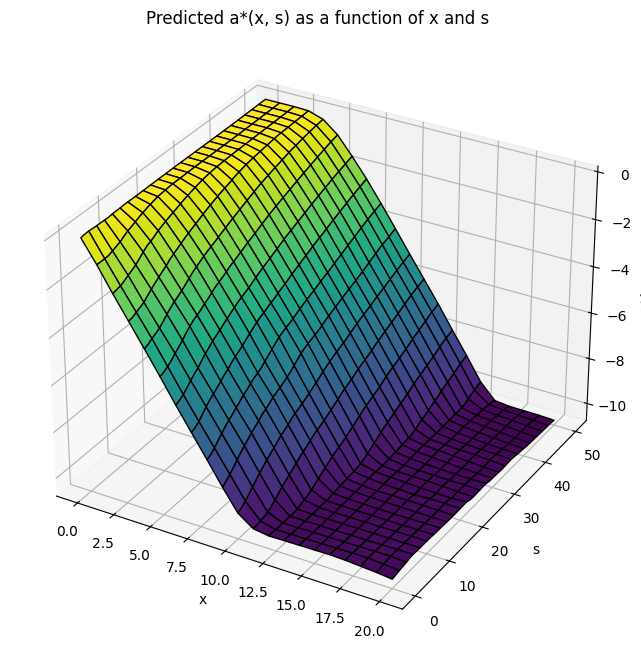

In [114]:
# Generate meshgrid for x and s
x_grid, s_grid = np.meshgrid(x_values, s_values)

# Prepare the input for the model
x_s_grid = np.vstack([x_grid.ravel(), s_grid.ravel()]).T
x_s_tensor = torch.tensor(x_s_grid, dtype=torch.float32)

# Predict a*(x,s) using the trained model
with torch.no_grad():
    a_pred_tensor = model_a(x_s_tensor)

# Reshape predictions to match the grid shape
a_pred = a_pred_tensor.numpy().reshape(x_grid.shape)

# Plot the 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(x_grid, s_grid, a_pred, cmap='viridis', edgecolor='k')

# Labels and title
ax.set_xlabel('x')
ax.set_ylabel('s')
ax.set_zlabel('a*(x, s)')
ax.set_title('Predicted a*(x, s) as a function of x and s')


plt.show()


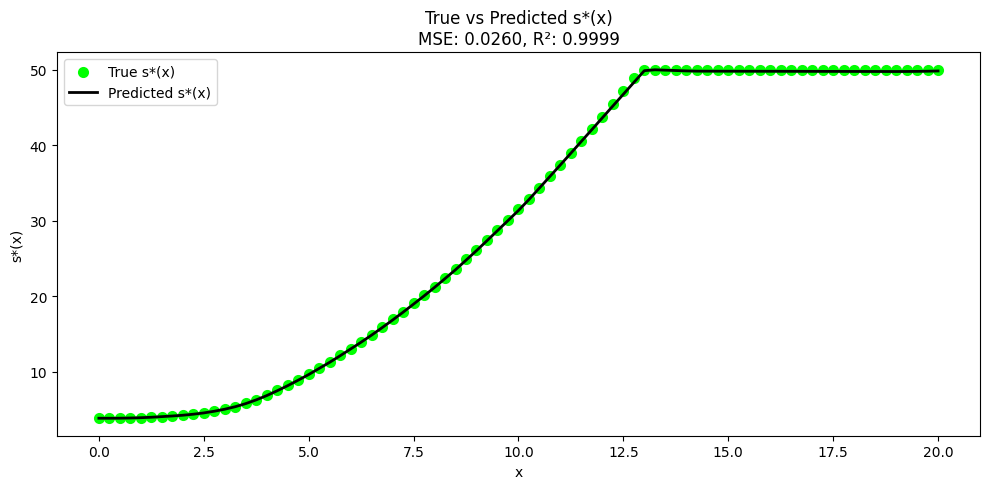

In [115]:
plt.figure(figsize=(10, 5))
plt.scatter(df2['x'], s_true, label='True s*(x)', linewidth=2, color='lime')
plt.plot(df2['x'], s_pred, color = 'black', label='Predicted s*(x)', linewidth=2)
plt.xlabel('x')
plt.ylabel('s*(x)')
plt.title(f'True vs Predicted s*(x)\nMSE: {mse_s:.4f}, R²: {r2_s:.4f}')
plt.legend()
plt.tight_layout()
plt.show()


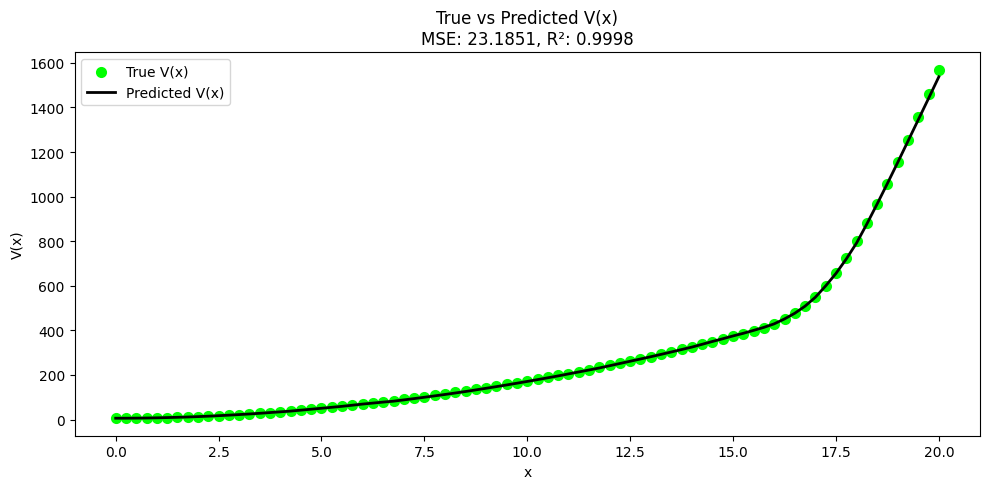

In [116]:
plt.figure(figsize=(10, 5))
plt.scatter(df2['x'], v_true, label='True V(x)', linewidth=2, color='lime')
plt.plot(df2['x'], v_pred, color='black', label='Predicted V(x)', linewidth=2)
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title(f'True vs Predicted V(x)\nMSE: {mse_v:.4f}, R²: {r2_v:.4f}')
plt.legend()
plt.tight_layout()
plt.show()


Random Forest Regressor


MSE for s*: 0.005470542085418266
R^2 for s*: 0.999984396578321
MSE for a*: 0.0001260798722670936
R^2 for a*: 0.9999867820464313
MSE for V(x): 9.778406360549624
R^2 for V(x): 0.9999205792624173


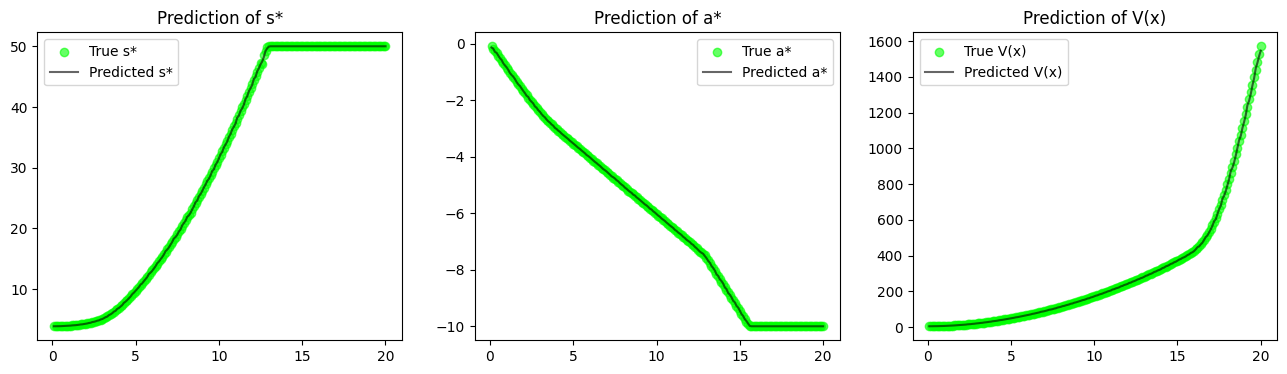

In [55]:
# Convert to arrays
X = np.array(x_values).reshape(-1, 1)
y_s = np.array(s_optimal)
y_a = np.array(a_optimal)
y_v = np.array(objective_values)

# Train RandomForestRegressor for s*
rf_s = RandomForestRegressor(n_estimators=100, random_state=42)
rf_s.fit(X, y_s)
y_s_pred = rf_s.predict(X)

print(f"MSE for s*: {mean_squared_error(y_s, y_s_pred)}")
print(f"R^2 for s*: {r2_score(y_s, y_s_pred)}")

# Train RandomForestRegressor for a* (using x and predicted s*)
X_combined = np.hstack((X, y_s.reshape(-1, 1)))
rf_a = RandomForestRegressor(n_estimators=100, random_state=42)
rf_a.fit(X_combined, y_a)
y_a_pred = rf_a.predict(X_combined)

print(f"MSE for a*: {mean_squared_error(y_a, y_a_pred)}")
print(f"R^2 for a*: {r2_score(y_a, y_a_pred)}")

# Train RandomForestRegressor for V(x) (using x)
rf_v = RandomForestRegressor(n_estimators=100, random_state=42)
rf_v.fit(X, y_v)
y_v_pred = rf_v.predict(X)

print(f"MSE for V(x): {mean_squared_error(y_v, y_v_pred)}")
print(f"R^2 for V(x): {r2_score(y_v, y_v_pred)}")

# Plot results
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.scatter(X, y_s, label="True s*", color ='lime' , alpha=0.6)
plt.plot(X, y_s_pred, label="Predicted s*", color = 'black', alpha=0.6)
plt.legend()
plt.title("Prediction of s*")

plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], y_a, label="True a*",color ='lime', alpha=0.6)
plt.plot(X[:, 0], y_a_pred, label="Predicted a*", color = 'black', alpha=0.6)
plt.legend()
plt.title("Prediction of a*")

plt.subplot(1, 3, 3)
plt.scatter(X, y_v, label="True V(x)", color = 'lime', alpha=0.6)
plt.plot(X, y_v_pred, label="Predicted V(x)", color = 'black',alpha=0.6)
plt.legend()
plt.title("Prediction of V(x)")

plt.show()



MSE for s* prediction on test data: 0.00222
MSE for a* prediction on test data: 0.00076
MSE for objective value prediction on test data: 69.08859


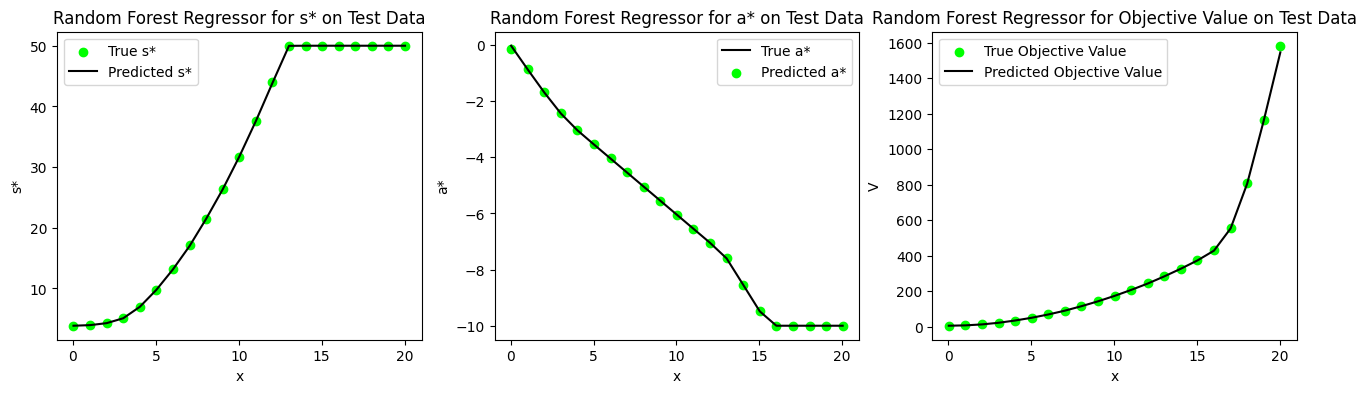

In [56]:
# Test for unseen data
X_test = np.arange(0.03, 20.05, 1).reshape(-1, 1)

s_optimal_test = np.array(s_optimal_test)
a_optimal_test = np.array(a_optimal_test)
objective_values_test = np.array(objective_values_test)

# Predict s*, a*, and objective values using the random forest models
s_pred_test = rf_s.predict(X_test)
a_pred_test = rf_a.predict(np.hstack([X_test, s_pred_test.reshape(-1,1)]))
obj_pred_test = rf_v.predict(X_test)

# Calculate the MSE for s*, a*, and objective values
mse_s = mean_squared_error(s_optimal_test, s_pred_test)
mse_a = mean_squared_error(a_optimal_test, a_pred_test)
mse_obj = mean_squared_error(objective_values_test, obj_pred_test)

print(f"\nMSE for s* prediction on test data: {mse_s:.5f}")
print(f"MSE for a* prediction on test data: {mse_a:.5f}")
print(f"MSE for objective value prediction on test data: {mse_obj:.5f}")


# Plot the results
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.scatter(X_test, s_optimal_test, color='lime', label='True s*')
plt.plot(X_test, s_pred_test, color='black', label='Predicted s*')
plt.legend()
plt.xlabel('x')
plt.ylabel('s*')
plt.title("Random Forest Regressor for s* on Test Data")

plt.subplot(1, 3, 2)
plt.plot(X_test, a_optimal_test, color='black', label='True a*')
plt.scatter(X_test, a_pred_test, color='lime', label='Predicted a*')
plt.legend()
plt.xlabel('x')
plt.ylabel('a*')
plt.title("Random Forest Regressor for a* on Test Data")

plt.subplot(1, 3, 3)
plt.scatter(X_test, objective_values_test, color='lime', label='True Objective Value')
plt.plot(X_test, obj_pred_test, color='black', label='Predicted Objective Value')
plt.legend()
plt.xlabel('x')
plt.ylabel('V')
plt.title("Random Forest Regressor for Objective Value on Test Data")

plt.show()